In [1]:
%pip install sophuspy


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import sophuspy as sp
from scipy.spatial.transform import Rotation as R

In [3]:
r = R.from_rotvec(np.pi/2 * np.array([0, 0, 1])) # 90 degreee rotation along the z-axis

rSP = sp.SO3(r.as_matrix())
print(rSP)

SO3([[2.22044604925031e-16,                   -1,                    0],
     [                   1, 2.22044604925031e-16,                    0],
     [                   0,                    0,                    1]])


In [11]:
# use logarithmic map to get the lie algebra
so3 = rSP.log()
print(so3)

# use the `hat` method to convert to a skew-symmetric matrix
so3sm = sp.SO3.hat(so3)
print(so3sm)

# convert skew-symmetric matrix to a vector using `vee`
# vee = sp.SO3.vee(so3sm) <-- The `vee` operator doesn't exist, will update this via a pull request to https://github.com/craigstar/SophusPy

# update by perturbation model 
print("update by perturbation model ")
update = np.array([1e-4, 0, 0])
rSP_updated = sp.SO3.exp(update) * rSP
print(rSP_updated)

[0.         0.         1.57079633]
[[ 0.         -1.57079633  0.        ]
 [ 1.57079633  0.         -0.        ]
 [-0.          0.          0.        ]]
update by perturbation model 
SO3([[                    0,                    -1,                     0],
     [          0.999999995,                     0, -9.99999998333334e-05],
     [ 9.99999998333334e-05,  2.03287907341032e-20,           0.999999995]])


In [17]:
se_rt = sp.SE3(r.as_matrix(), [1, 0, 0])
se3 = se_rt.log()
print(se3)
print(sp.SE3.hat(se3))

# update the model
updateSE3 = np.array([1e-4, 0, 0, 0, 0, 0])
print(f"Updated SE3 = {sp.SE3.exp(updateSE3) * se_rt}")

[ 0.78539816 -0.78539816  0.          0.          0.          1.57079633]
[[ 0.         -1.57079633  0.          0.78539816]
 [ 1.57079633  0.         -0.         -0.78539816]
 [-0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Updated SE3 = SE3([[2.22044604925031e-16,                   -1,                    0,               1.0001],
     [                   1, 2.22044604925031e-16,                    0,                    0],
     [                   0,                    0,                    1,                    0],
     [                   0,                    0,                    0,                    1]])


# Evaluating a trajectory

Total Squared error = 2981.712217670494
Mean Squared error = 4.87207878704329
Root Mean Squared error = 2.207278592983516


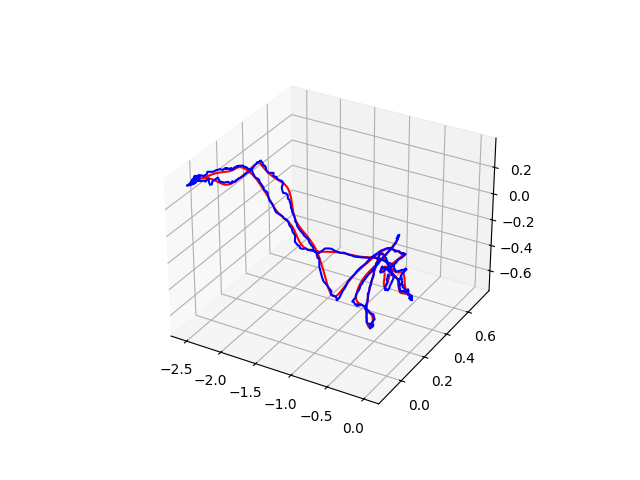

In [52]:
# Use Sophus instead of your transforms class to represent the trajectories

def read_trajectory(atFile):
    lines = np.loadtxt(atFile)
    data = []
    for i in range(lines.shape[0]):
        time = lines[i, 0]
        t = np.array(lines[i,1:4])
        q = lines[i, 4:] # quaternions are already in the scalar last format
        rotation = R.from_quat(q)
        tf = sp.SE3(rotation.as_matrix(), t)
        data.append(tf)
    return data, lines


groundtruth, glines = read_trajectory("./resources/groundtruth.txt")
estimated, elines = read_trajectory("./resources/estimated.txt")

assert len(groundtruth) == len(estimated)

# Compute RMSE
totalError = 0
for i in range(len(groundtruth)):
    p1 = estimated[i]
    p2 = groundtruth[i]
    error = np.linalg.norm((p2.inverse() * p1).log())
    errorSq = error ** 2
    totalError += errorSq

print(f"Total Squared error = {totalError}")
mse = totalError / len(groundtruth)
print(f"Mean Squared error = {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared error = {rmse}")

# Trajectory drawing
import matplotlib.pyplot as plt
# Ensure the required backend is installed using `pip install ipympl`
%matplotlib widget 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(glines[:,1], glines[:,2], glines[:,3], 'r-')
ax.plot(elines[:,1], elines[:,2], elines[:,3], 'b-')

plt.show()

%matplotlib inline
    